In [1]:
# forked from https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [2]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

from _utils.u_constant import PATH_ROOT
path = PATH_ROOT + "Code projects/Python/kaggle/Titanic Machine Learning from Disaster/"

## 1. Feature Exploration, Engineering and Cleaning

In [3]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

PassengerId = test["PassengerId"]  # Store target passengerids for easy access
full_data = [train, test]
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print("Train Data Info:")
train.info(null_counts=True)
print("-" * 40)
print("Test Data Info:")
test.info(null_counts=True)

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null 

In [5]:
def get_title(name):
    s = re.search(pattern="([A-Za-z]+)\.", string=name).group(1)
    if s is None:
        return ""
    if s in ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return "Rare"
    if s in ["Mlle", "Ms"]:
        return "Miss"
    if s in ["Mme"]:
        return "Mrs"
    return s    

def discretize_fare(fare):
    if fare <= 7.91:
        return 0
    if fare <= 14.454:
        return 1
    if fare <= 31.0:
        return 2
    return 3

def discretize_age(age):
    if age <= 16:
        return 0
    if age <= 32:
        return 1
    if age <= 48:
        return 2
    if age <= 64:
        return 3
    return 4

In [6]:
drop_columns = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]
for data in full_data:
    data["Name_length"] = data["Name"].apply(len)
    data["Has_Cabin"] = data["Cabin"].apply(lambda x: 1 if isinstance(x, str) else 0)
    data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
    data["IsAlone"] = (data["FamilySize"] <= 1).astype(int)
    data["Embarked"] = data["Embarked"].fillna("S")
    data["Fare"] = data["Fare"].fillna(train["Fare"].median())
    
    age_avg = data["Age"].mean()
    age_std = data["Age"].std()
    age_null_count = data["Age"].isnull().sum()
    np.random.seed(seed = 0)
    age_null_random_list = np.random.randint(low=age_avg - age_std, high=age_avg + age_std, size=age_null_count)
    data.loc[pd.isnull(data["Age"]), "Age"] = age_null_random_list
    
    data["Title"] = data["Name"].apply(get_title)
    data["Sex"] = data["Sex"].map({"female": 1, "male": 0}).astype(int)
    data["Title"] = data["Title"].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}).fillna(0)
    data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
    data["Fare"] = data["Fare"].apply(discretize_fare)
    data["Age"] = data["Age"].apply(discretize_age)
    data.drop(drop_columns, axis=1, inplace=True)

In [7]:
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,0,1,0,0,0,23,0,2,0,1
1,1,1,1,2,0,3,1,51,1,2,0,3
2,1,3,1,1,0,1,0,22,0,1,1,2
3,1,1,1,2,0,3,0,44,1,2,0,3
4,0,3,0,2,0,1,0,24,0,1,1,1


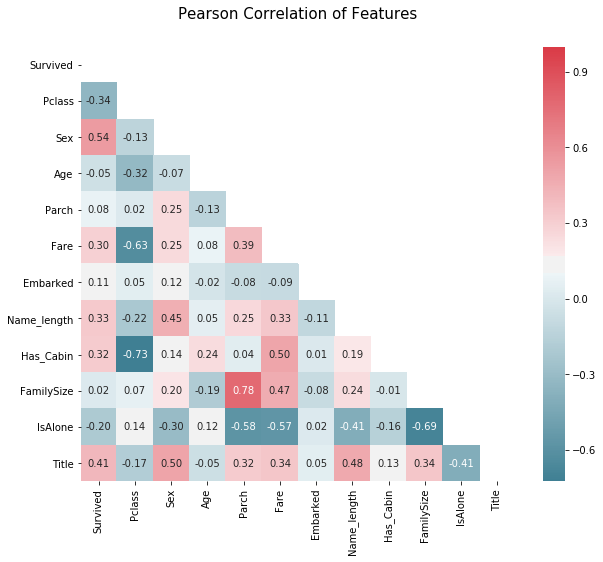

In [8]:
# plot corr map
fig, axe = plt.subplots(figsize=(10, 8))
corr = train.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)
g = sns.heatmap(data=corr, cmap=cmap, mask=mask, square=True, annot=True, fmt="0.2f", ax=axe)
axe.set_title("Pearson Correlation of Features", size=15, y=1.05)
fig.show()  # there are not too many features strongly correlated with one another

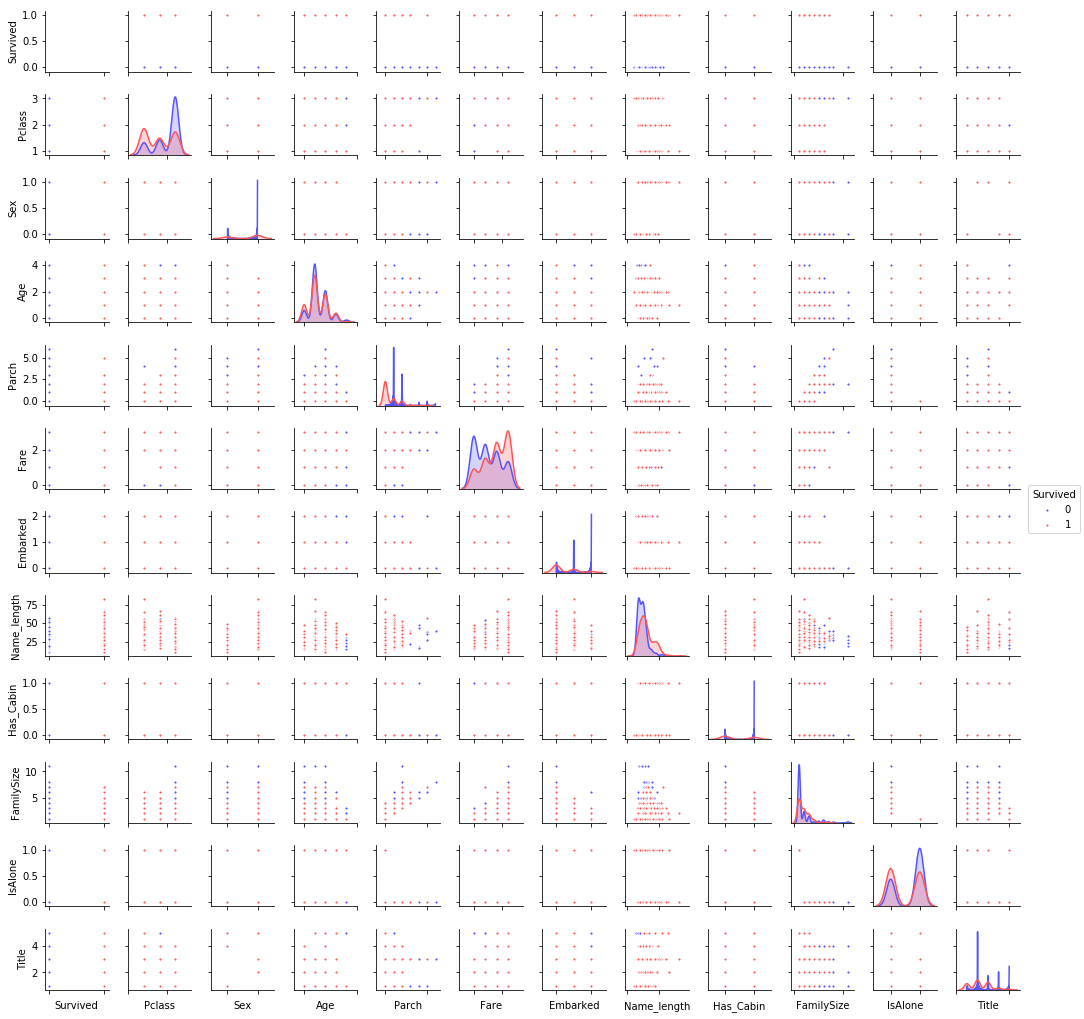

In [9]:
# plot pair fig
g = sns.pairplot(data=train, hue="Survived", palette="seismic", size=1.2, 
                 diag_kind="kde", diag_kws={"shade": True}, plot_kws={"s": 10})
g.set(xticklabels=[])


## 2. Ensembling & Stacking models

In [10]:
ntrain = len(train)
ntest = len(test)
X_train = train.drop("Survived", axis=1).values
y_train = train["Survived"].values
X_test = test.values

SEED = 0
NFOLDS = 5
KF = StratifiedKFold(n_splits=NFOLDS, random_state=SEED).split(X_train, y_train)

class SkHelper:
    
    def __init__(self, clf, seed=0, params=None):
        params["random_state"] = seed
        self.clf = clf(**params)
        
    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        
    def predict(self, X):
        self.clf.predict(X)
        
#     def fit(self, X, y):
#         return self.train(X, y)
    
    def feature_importance(self, X, y):
        self.clf.fit(X, y)
        return self.clf.feature_importances_
    

In [11]:
def get_oof(clf, X_train, y_train, X_test):
    """
    out-of-fold Predictions
    """    
    oof_train = np.zeros((len(X_train), ))
    oof_test_kf = np.empty((len(X_test), NFOLDS))
    
    for i, (train_index, test_index) in enumerate(KF):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[test_index]
        
        clf.train(X_tr, y_tr)
        
        oof_train[test_index] = clf.predict(X_te)
        oof_test_kf[:, i] = clf.predict(X_test)
    
    oof_test = np.mean(oof_test_kf, axis=1)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [12]:
rf_params = {"n_jobs": -1, 
             "n_estimators": 500, 
             "warm_start": True, 
             "max_depth": 6, 
             "min_samples_leaf": 2, 
             "max_features": "sqrt", 
             "verbose": 0
            }

et_params = {"n_jobs": -1, "n_estimators": 500, "max_depth": 8, "min_samples_leaf": 2, "verbose": 0}
ada_params = {"n_estimators": 500, "learning_rate": 0.75}
gb_params = {"n_estimators": 500, "max_depth": 5, "min_samples_leaf": 2, "verbose": 0}
svc_params = {"kernel": "linear", "C": 0.025}

In [13]:
rf = SkHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SkHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SkHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SkHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SkHelper(clf=SVC, seed=SEED, params=svc_params)

In [14]:
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train, X_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, X_train, y_train, X_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, X_train, y_train, X_test) # Support Vector Classifier


In [15]:
rt_feature = rf.feature_importance(X_train, y_train)
et_feature = et.feature_importance(X_train, y_train)
ada_feature = ada.feature_importance(X_train, y_train)
gb_feature = gb.feature_importance(X_train, y_train)

In [16]:
cols = train.drop("Survived", axis=1).columns.values
feature_df = pd.DataFrame({"features": cols, 
                           "RF": rt_feature, 
                           "ET": et_feature, 
                           "Ada": ada_feature, 
                           "GB": gb_feature
                          })
feature_df

,features,RF,ET,Ada,GB
0,Pclass,0.113508,0.121094,0.030,0.086182
1,Sex,0.243307,0.375408,0.010,0.012657
2,Age,0.032189,0.026834,0.016,0.052769
3,Parch,0.018528,0.016138,0.062,0.013763
4,Fare,0.049978,0.057241,0.038,0.051175
5,Embarked,0.022016,0.028392,0.010,0.021444
6,Name_length,0.110416,0.048535,0.694,0.171826
7,Has_Cabin,0.066773,0.085766,0.012,0.037237
8,FamilySize,0.071701,0.044173,0.052,0.111715
9,IsAlone,0.010232,0.022103,0.006,0.007372


In [17]:
trace = go.Scatter(x=feature_df["features"].values, 
                   y=feature_df["RF"].values, 
                   mode="markers", 
                   marker={"sizemode": "diameter", 
                           "sizeref": 1, 
                           "size": 25, 
                           "color": feature_df["RF"].values, 
                           "colorscale": "Portland", 
                           "showscale": True
                          }, 
                   text=feature_df["features"].values)
data = [trace]
layout = go.Layout(autosize=True, 
                   title="Random Forest Feature Importance", 
                   hovermode="closest", 
                   yaxis={"title": "Feature Importance", "ticklen": 5, "gridwidth": 2}, 
                   showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)
